In [1]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import matplotlib.pyplot as plt
from IPython.display import Math, Latex
plt.style.use('seaborn-v0_8-whitegrid')
from tqdm.notebook import tqdm
import seaborn as sns
import sampler_functions as sf
import analysis as an



In [2]:

# Data Generation Parameters
m = 25                 # Number of data points in our sample
k = 2.0                # Degrees of freedom for the Student's t-distribution
mu_true = 10.0           # The true 'secret' location parameter we want to eventually find

# p(mu) ~ Normal(mu_prior, std_prior^2)
prior_mean = 0.0
prior_std = 20.0

# Gibbs Sampler Parameters
num_iterations_T = 20000
proposal_std_mu = 0.9    # Standard deviation for the Metropolis proposal for mu

params = {
    'm': m,
    'k': k,
    'mu_true': mu_true,
    'prior_mean': prior_mean,
    'prior_std': prior_std,
    'num_iterations_T': num_iterations_T,
    'proposal_std_mu': proposal_std_mu
}


print("Parameters defined:")
for key, val in params.items():
    print(f"- {key}: {val}")

Parameters defined:
- m: 25
- k: 2.0
- mu_true: 10.0
- prior_mean: 0.0
- prior_std: 20.0
- num_iterations_T: 20000
- proposal_std_mu: 0.9



--- Data Simulation and MLE Calculation ---
The true (secret) mu is: 10.0000
The sample mean is: 9.4355
The calculated MLE (mu*) is: 9.4345


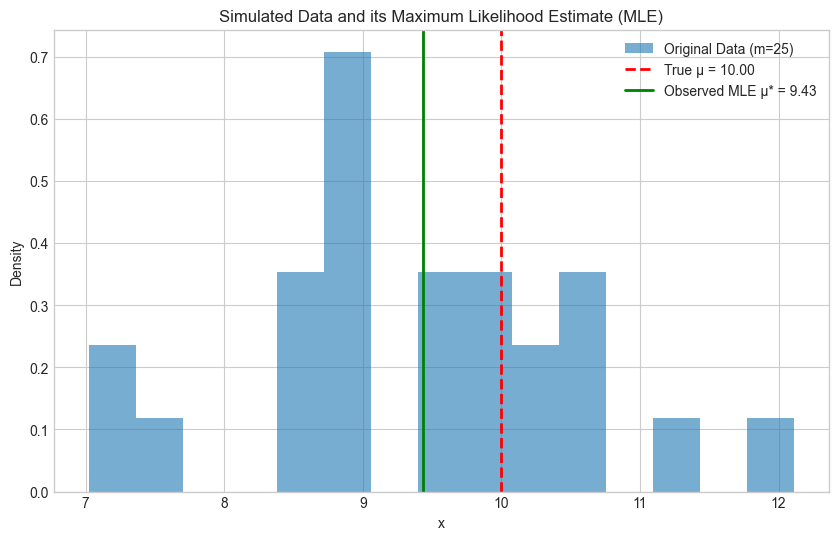

In [3]:
# np.random.seed(42)

# 1. Simulate the original "hidden" dataset from a t-distribution
x_original = stats.t.rvs(df=params['k'], loc=params['mu_true'], scale=1, size=params['m'])

mu_star = sf.get_mle(x_original, params)

# add mu_star to our parameters dictionary
params['mu_star'] = mu_star

print(f"\n--- Data Simulation and MLE Calculation ---")
print(f"The true (secret) mu is: {params['mu_true']:.4f}")
print(f"The sample mean is: {np.mean(x_original):.4f}")
print(f"The calculated MLE (mu*) is: {params['mu_star']:.4f}")

# Plot
plt.figure(figsize=(10, 6))
plt.hist(x_original, bins=15, density=True, alpha=0.6, label=f"Original Data (m={params['m']})")
plt.axvline(params['mu_true'], color='red', linestyle='--', linewidth=2, label=f"True μ = {params['mu_true']:.2f}")
plt.axvline(params['mu_star'], color='green', linestyle='-', linewidth=2, label=f"Observed MLE μ* = {params['mu_star']:.2f}")
plt.title("Simulated Data and its Maximum Likelihood Estimate (MLE)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()

In [4]:

# Initialize the parameter mu at the MLE, mu_star
mu_0 = params['mu_star']

# Initialize the latent data vector x.
x_0 = np.full(shape=params['m'], fill_value=params['mu_star'])

mu_chain = np.zeros(params['num_iterations_T'])
mu_chain[0] = mu_0

x_current = x_0

print("--- Initialization ---")
print(f"Initialized mu_0 = {mu_chain[0]:.4f}")
print(f"Initialized x_0 as a vector of {params['m']} values, all equal to {x_current[0]:.4f}")
# Verify that the MLE of our x_0 is indeed mu_star


--- Initialization ---
Initialized mu_0 = 9.4345
Initialized x_0 as a vector of 25 values, all equal to 9.4345


In [5]:
# --- Block 5: Metropolis-Hastings step for mu ---

def log_posterior_mu(mu, data_x, k, prior_mean, prior_std):
    """
    Calculates the log of the posterior probability of mu, p(mu | x).
    This is proportional to log(likelihood) + log(prior).
    """
    # Calculate the log-likelihood: log( p(x | mu) )
    # This is the sum of the log-PDF of the t-distribution for each data point.
    log_likelihood = np.sum(stats.t.logpdf(data_x, df=k, loc=mu, scale=1))

    # Calculate the log-prior: log( p(mu) )
    # This is the log-PDF of our Normal prior for mu.
    log_prior = stats.norm.logpdf(mu, loc=prior_mean, scale=prior_std)

    # The log-posterior is the sum of the two.
    return log_likelihood + log_prior

def update_mu_metropolis(mu_current, x_current, params):
    """
    Performs one Metropolis-Hastings step to get a new sample for mu.
    """
    # 1. Propose a new candidate for mu from a symmetric proposal distribution.
    #    We use a Normal distribution centered at the current mu.
    mu_candidate = np.random.normal(loc=mu_current, scale=params['proposal_std_mu'])

    # 2. Calculate the log-posterior for the current and candidate mu values.
    log_post_current = log_posterior_mu(
        mu=mu_current,
        data_x=x_current,
        k=params['k'],
        prior_mean=params['prior_mean'],
        prior_std=params['prior_std']
    )
    log_post_candidate = log_posterior_mu(
        mu=mu_candidate,
        data_x=x_current,
        k=params['k'],
        prior_mean=params['prior_mean'],
        prior_std=params['prior_std']
    )

    # 3. Calculate the acceptance probability (alpha) in log-space.
    #    alpha = min(1, p(candidate)/p(current))
    #    log(alpha) = min(0, log(p(candidate)) - log(p(current)))
    log_acceptance_ratio = log_post_candidate - log_post_current
    acceptance_prob = min(1.0, np.exp(log_acceptance_ratio))

    # 4. Accept or reject the candidate.
    if np.random.uniform(0, 1) < acceptance_prob:
        return mu_candidate
    else:
        return mu_current




--- Tuning Metropolis Sampler for μ ---
Running for 50000 iterations with proposal_std_mu = 0.90


Sampling μ:   0%|          | 0/49999 [00:00<?, ?it/s]

Sampler finished. Overall Acceptance Rate: 32.18%


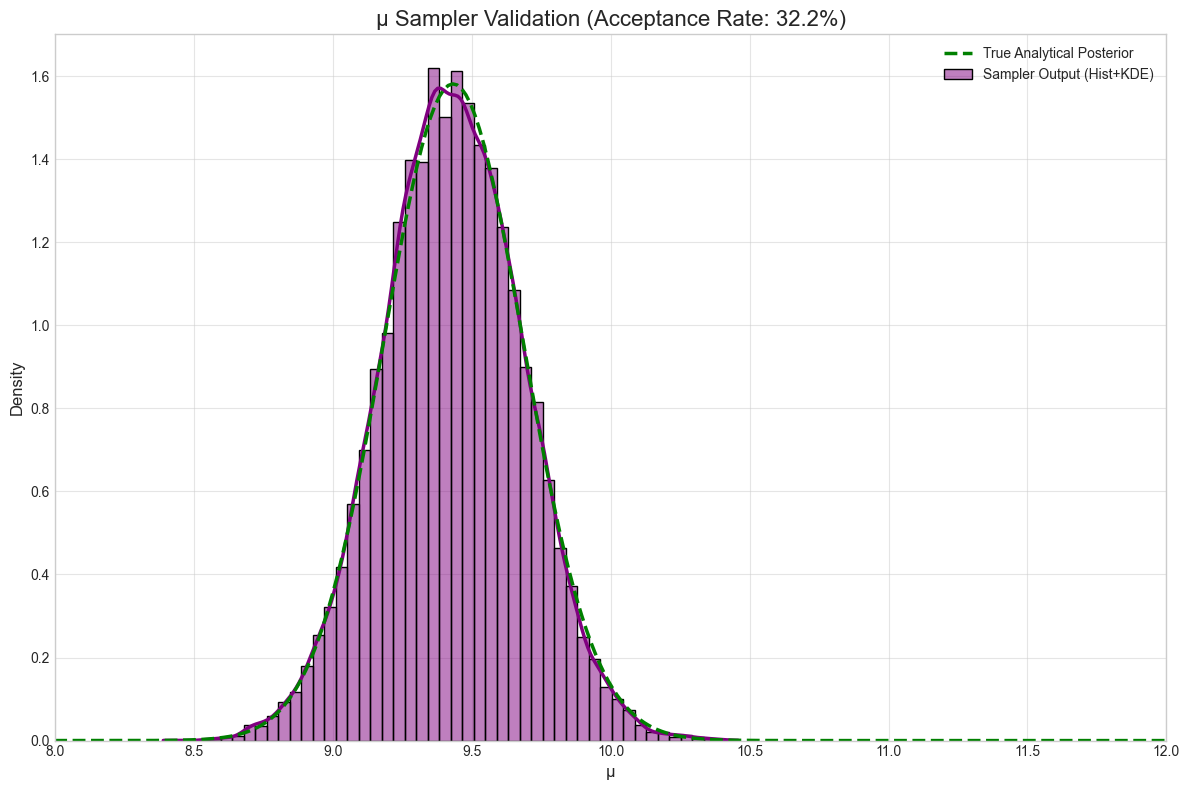

In [30]:
an.tune_and_plot_mu_sampler(
    x_original=x_original,
    params=params,
    mu_start=20,
    num_iterations=50000,
    save_path=None
)


In [7]:
# --- Block 5-C: Validation of the mu-update Step with True Posterior Overlay ---
    
# Use the new parameters
params['proposal_std_mu'] = 0.9

print("\n--- Validating the Metropolis-Hastings Step for mu in Isolation ---")

# --- 1. Setup the Validation Run ---
num_validation_steps = 50000
fixed_x = x_original
start_mu = 7.5

mu_validation_chain = np.zeros(num_validation_steps)
mu_validation_chain[0] = start_mu
validation_acceptance_count = 0

print(f"Running {num_validation_steps} iterations with a fixed x vector.")
print(f"Starting mu at {start_mu:.2f} and targeting the posterior conditional on x_original.")




--- Validating the Metropolis-Hastings Step for mu in Isolation ---
Running 50000 iterations with a fixed x vector.
Starting mu at 7.50 and targeting the posterior conditional on x_original.


In [8]:
# --- Block 6: Add Tuning Parameter for the z-sampler ---

# The domain of z is small, so proposal standard deviation for z should also be small.
proposal_std_z = 0.05
params['proposal_std_z'] = proposal_std_z

#  domain boundaries of z
#  (-1/(2*sqrt(k)), 1/(2*sqrt(k)))
z_domain_half_width = 1 / (2 * np.sqrt(params['k']))
params['z_domain'] = (-z_domain_half_width, z_domain_half_width)

print("--- Updated Parameters ---")
for key, val in params.items():
    if key == 'z_domain':
        print(f"- {key}: ({val[0]:.4f}, {val[1]:.4f})")
    else:
        print(f"- {key}: {val}")

--- Updated Parameters ---
- m: 25
- k: 2.0
- mu_true: 10.0
- prior_mean: 0.0
- prior_std: 20.0
- num_iterations_T: 20000
- proposal_std_mu: 0.9
- mu_star: 9.434549719020055
- proposal_std_z: 0.05
- z_domain: (-0.3536, 0.3536)


In [9]:
# --- Block 7: Core Mathematical Transformation Functions ---

def psi(y, k):
    """The forward transformation from y-space to z-space."""
    return y / (k + y**2)

def psi_inverse(z, k):
    """
    The inverse transformation from z-space to y-space.
    Returns a tuple of the two possible y values (y_minus, y_plus).
    """
    # edge case where z is very close to zero
    if np.isclose(z, 0):
        return 0.0, 0.0 # The only inverse is y=0

    # Ensure the value under the square root is non-negative
    discriminant = 1 - 4 * k * z**2

    if discriminant < 0:
        # This case should not be reached if z is in the valid domain
        print(f"Warning: Negative discriminant for z={z:.4f}")
        return np.nan, np.nan

    sqrt_discriminant = np.sqrt(discriminant)
    y_plus = (1 + sqrt_discriminant) / (2 * z)
    y_minus = (1 - sqrt_discriminant) / (2 * z)

    return tuple(sorted((y_minus, y_plus)))

def psi_prime_abs(y, k):
    """
    The absolute value of the derivative of the psi function.
    This is the "stretching factor" or Jacobian for the 1D transformation.
    """
    numerator = k - y**2
    denominator = (k + y**2)**2
    # The denominator is always non-negative, so we only need the abs of the numerator.
    return np.abs(numerator) / denominator



In [10]:
from scipy.special import logsumexp

# --- Block 8: Probability Density Functions ---

def f_y(y, mu_current, mu_star, k):

    loc = mu_current - mu_star
    return stats.t.pdf(y, df=k, loc=loc, scale=1)

def log_q_density(z, mu_current, mu_star, k, z_domain):
    """
    Calculates the log of the pushforward probability density, log(q(z)),
    using vectorization and the log-sum-exp trick.
    """
    if not (z_domain[0] < z < z_domain[1]):
        return -np.inf

    y_minus, y_plus = psi_inverse(z, k)

    if np.isnan(y_minus):
        return -np.inf

    # Handle the special case where the two branches are the same (e.g., z=0)
    # In this case, there's only one term in the sum, no vectorization needed.
    if np.isclose(y_minus, y_plus):
        log_fy = stats.t.logpdf(y_minus, df=k, loc=mu_current - mu_star, scale=1)
        log_psi_prime = np.log(psi_prime_abs(y_minus, k) + 1e-30)
        return log_fy - log_psi_prime


    # Create a single array of the two y values
    y_vals = np.array([y_minus, y_plus])

    # Call logpdf and psi_prime_abs only ONCE on the array
    log_fy_vals = stats.t.logpdf(y_vals, df=k, loc=mu_current - mu_star, scale=1)
    log_psi_prime_vals = np.log(psi_prime_abs(y_vals, k) + 1e-30)

    # Calculate both log terms at once with element-wise subtraction
    log_terms = log_fy_vals - log_psi_prime_vals

    # Combine the two log terms using the stable log-sum-exp trick
    return logsumexp(log_terms)

In [ ]:
# --- Block 9: M-H Sampler for z_i  ---

def log_q_tilde(z, delta, mu_current, mu_star, k, z_domain):
    """
    Calculates the log of the target density log(q_tilde(z)).
    log(q_tilde(z)) = log(q(z)) + log(q(delta - z))

    """
    # Calculate the log-density of the z component
    log_q_z = log_q_density(z, mu_current, mu_star, k, z_domain)

    # Calculate the log-density of the partner component
    log_q_partner = log_q_density(delta - z, mu_current, mu_star, k, z_domain)

    # The log of the product is the sum of the logs.
    # If either term is -inf, the sum will correctly be -inf.
    return log_q_z + log_q_partner


def sample_z_i(z_start, delta, mu_current, mu_star, k, z_domain, proposal_std_z, proposal_method='gaussian'):
    """
    Performs one Metropolis-Hastings step for z_i with a corrected standard
    Gaussian proposal method.
    """
    valid_min = max(z_domain[0], delta - z_domain[1])
    valid_max = min(z_domain[1], delta - z_domain[0])
    
    if valid_min >= valid_max:
        return z_start, False

    log_proposal_ratio = 0.0
    
    if proposal_method == 'uniform':
        z_candidate = np.random.uniform(valid_min, valid_max)

    elif proposal_method == 'truncated_gaussian':
        a, b = (valid_min - z_start) / proposal_std_z, (valid_max - z_start) / proposal_std_z
        z_candidate = stats.truncnorm.rvs(a, b, loc=z_start, scale=proposal_std_z)
        log_forward_prob = stats.truncnorm.logpdf(z_candidate, a, b, loc=z_start, scale=proposal_std_z)
        a_rev, b_rev = (valid_min - z_candidate) / proposal_std_z, (valid_max - z_candidate) / proposal_std_z
        log_reverse_prob = stats.truncnorm.logpdf(z_start, a_rev, b_rev, loc=z_candidate, scale=proposal_std_z)
        log_proposal_ratio = log_reverse_prob - log_forward_prob

    else: # 'gaussian' proposal
        z_candidate = np.random.normal(loc=z_start, scale=proposal_std_z)

    # Calculate acceptance probability. If z_candidate is outside the valid
    # domain, log_post_candidate will be -inf, leading to rejection.
    log_post_current = log_q_tilde(z_start, delta, mu_current, mu_star, k, z_domain)
    log_post_candidate = log_q_tilde(z_candidate, delta, mu_current, mu_star, k, z_domain)
    
    log_acceptance_ratio = (log_post_candidate - log_post_current) + log_proposal_ratio
    
    if np.random.uniform(0, 1) < np.exp(log_acceptance_ratio):
        return z_candidate, True
    else:
        return z_start, False



In [12]:
def tune_and_plot_z_sampler(x_original, indices, params, proposal_method, num_iterations=10000):
    """
    Runs the z_i sampler, calculates acceptance rate, and plots the output
    against the true target density q_tilde(z).
    """
    i, j = indices
    k = params['k']
    mu_star = params['mu_true'] # Assuming mu_star is mu_true for this test
    z_domain = params['z_domain']
    proposal_std_z = params['proposal_std_z']
    
    # Calculate delta for the chosen pair
    y_i, y_j = x_original[i] - mu_star, x_original[j] - mu_star
    z_i, z_j = sf.psi(y_i, k), sf.psi(y_j, k)
    delta = z_i + z_j

    print(f"\n--- Tuning Sampler for z_i with method: '{proposal_method}' ---")
    print(f"Proposal std dev = {proposal_std_z:.3f}")
    
    # Run the sampler
    z_chain = [z_i]
    acceptance_count = 0
    for _ in tqdm(range(1, num_iterations), desc=f"Sampling z_i ({proposal_method})"):
        z_new, accepted = sample_z_i(z_chain[-1], delta, mu_star, mu_star, k, z_domain, proposal_std_z, proposal_method)
        if accepted:
            acceptance_count += 1
        z_chain.append(z_new)
        
    acceptance_rate = acceptance_count / (num_iterations - 1)
    print(f"Acceptance Rate: {acceptance_rate:.2%}")

    # Calculate the true target density for plotting
    valid_min = max(z_domain[0], delta - z_domain[1])
    valid_max = min(z_domain[1], delta - z_domain[0])
    z_grid = np.linspace(valid_min, valid_max, 500)
    log_q_tilde_vals = [log_q_tilde(z, delta, mu_star, mu_star, k, z_domain) for z in z_grid]
    unnorm_q_tilde = np.exp(log_q_tilde_vals - np.max(log_q_tilde_vals))
    true_q_tilde = unnorm_q_tilde / np.trapezoid(unnorm_q_tilde, z_grid)

    # Plot the results
    plt.figure(figsize=(12, 8))
    sns.histplot(z_chain[int(num_iterations*0.2):], kde=True, stat='density', bins=50, label="Sampler Output")
    plt.plot(z_grid, true_q_tilde, color='red', lw=2.5, linestyle='--', label="True Target Density (q_tilde)")
    plt.title(f"z_i Sampler Validation ({proposal_method}) | Acceptance: {acceptance_rate:.1%}")
    plt.xlabel("z_i")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()



In [13]:
def plot_q_density_and_overlap(x_original, indices, params, sf):
    """
    Generates two plots for a given pair of indices:
    1. The density of the pushforward distribution, q(z).
    2. The overlap of q(z) and q(delta - z) which forms q_tilde(z).
    """
    i, j = indices
    k = params['k']
    mu_star = params['mu_true']
    z_domain = params['z_domain']

    # Calculate delta for the chosen pair
    y_i, y_j = x_original[i] - mu_star, x_original[j] - mu_star
    z_i, z_j = sf.psi(y_i, k), sf.psi(y_j, k)
    delta = z_i + z_j

    print(f"\n--- Visualizing Densities for Indices {indices} ---")
    print(f"Delta (z_i + z_j) = {delta:.4f}")

    # --- 1. Calculate and Plot q(z) ---
    # Use a grid over the entire valid domain of z
    z_grid_full = np.linspace(z_domain[0] + 1e-6, z_domain[1] - 1e-6, 1000)
    log_q_vals = [log_q_density(z, mu_star, mu_star, k, z_domain) for z in z_grid_full]
    unnorm_q = np.exp(log_q_vals - np.max(log_q_vals))
    q_density = unnorm_q / np.trapezoid(unnorm_q, z_grid_full)

    # plt.figure(figsize=(12, 8))
    # plt.plot(z_grid_full, q_density, color='blue', lw=2.5)
    # plt.title("Pushforward Density q(z)", fontsize=16)
    # plt.xlabel("z")
    # plt.ylabel("Density")
    # plt.grid(alpha=0.5)
    # plt.show()

    # --- 2. Calculate and Plot the Overlap for q_tilde(z) ---
    # Define the valid interval where q_tilde(z) is non-zero
    valid_min = max(z_domain[0], delta - z_domain[1])
    valid_max = min(z_domain[1], delta - z_domain[0])
    
    # --- ADDED PRINT STATEMENTS ---
    print(f"Valid domain for q_tilde(z): ({valid_min:.4f}, {valid_max:.4f})")
    
    if valid_min >= valid_max:
        print("No valid overlap for q_tilde(z). Skipping plot.")
        return

    z_grid_tilde = np.linspace(valid_min, valid_max, 500)
    
    # Calculate q(z) on the tilde grid
    log_q_z_vals = [log_q_density(z, mu_star, mu_star, k, z_domain) for z in z_grid_tilde]
    unnorm_q_z = np.exp(log_q_z_vals - np.max(log_q_z_vals))
    q_z_on_tilde_grid = unnorm_q_z / np.trapezoid(unnorm_q, z_grid_full) # Normalize with original area

    # Calculate q(delta - z) on the tilde grid
    log_q_partner_vals = [log_q_density(delta - z, mu_star, mu_star, k, z_domain) for z in z_grid_tilde]
    unnorm_q_partner = np.exp(log_q_partner_vals - np.max(log_q_partner_vals))
    q_partner_on_tilde_grid = unnorm_q_partner / np.trapezoid(unnorm_q, z_grid_full) # Normalize with original area

    # Calculate q_tilde(z) = q(z) * q(delta - z)
    unnorm_q_tilde = q_z_on_tilde_grid * q_partner_on_tilde_grid
    true_q_tilde = unnorm_q_tilde / np.trapezoid(unnorm_q_tilde, z_grid_tilde)

    plt.figure(figsize=(12, 8))
    plt.plot(z_grid_tilde, q_z_on_tilde_grid, color='blue', lw=2.5, label="q(z)")
    plt.plot(z_grid_tilde, q_partner_on_tilde_grid, color='orange', lw=2.5, label="q(delta - z)")
    plt.plot(z_grid_tilde, true_q_tilde, color='green', lw=3, linestyle='--', label="q_tilde(z) (Normalized)")
    plt.fill_between(z_grid_tilde, true_q_tilde, color='green', alpha=0.2, label="Area of q_tilde")
    
    # Add vertical lines to highlight the exact domain of q_tilde
    plt.axvline(valid_min, color='purple', linestyle=':', lw=2, label=f'q_tilde min={valid_min:.3f}')
    plt.axvline(valid_max, color='purple', linestyle=':', lw=2, label=f'q_tilde max={valid_max:.3f}')
    
    plt.title("Overlap Forming the Target Density q_tilde(z)", fontsize=16)
    plt.xlabel("z")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(alpha=0.5)
    plt.show()


Valid domain for z_i (np.float64(-0.35355339059327373), np.float64(0.35355339059327373))

--- Visualizing Densities for Indices (2, 7) ---
Delta (z_i + z_j) = -0.6815
Valid domain for q_tilde(z): (-0.3536, -0.3280)


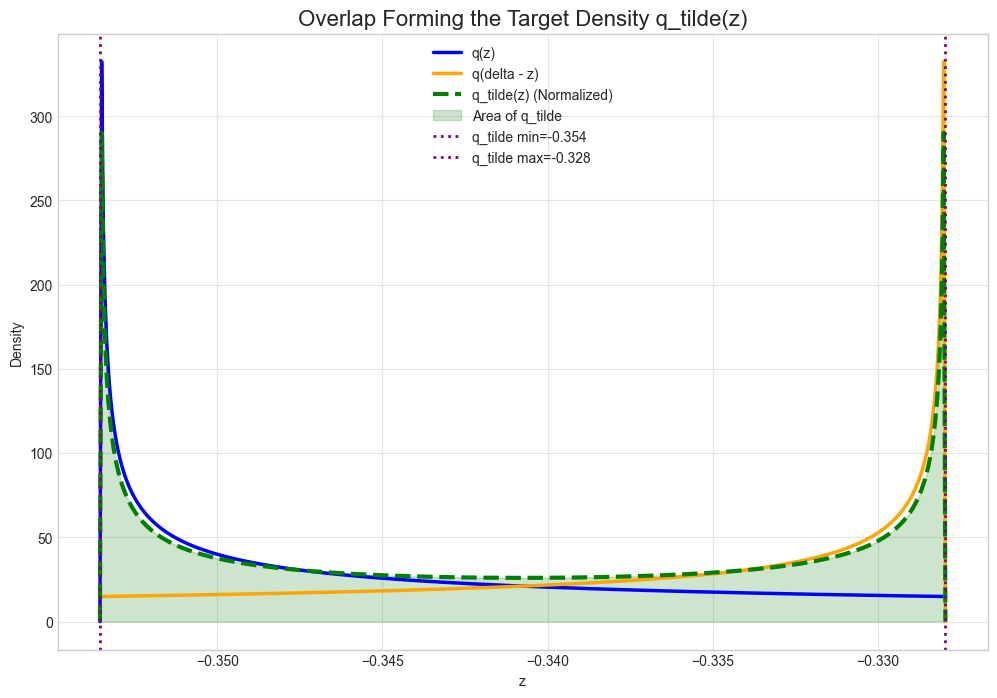

In [14]:
print('Valid domain for z_i',params['z_domain'])

test_dataset_for_viz = x_original  
test_indices_for_viz = (2,7) 

# 2. RUN THE VISUALIZATION FUNCTION
plot_q_density_and_overlap(
    x_original=test_dataset_for_viz,
    indices=test_indices_for_viz,
    params=params,
    sf=sf # Your sampler_functions module
)




--- Tuning Sampler for z_i with method: 'uniform' ---
Proposal std dev = 0.900


Sampling z_i (uniform):   0%|          | 0/19999 [00:00<?, ?it/s]

Acceptance Rate: 71.84%


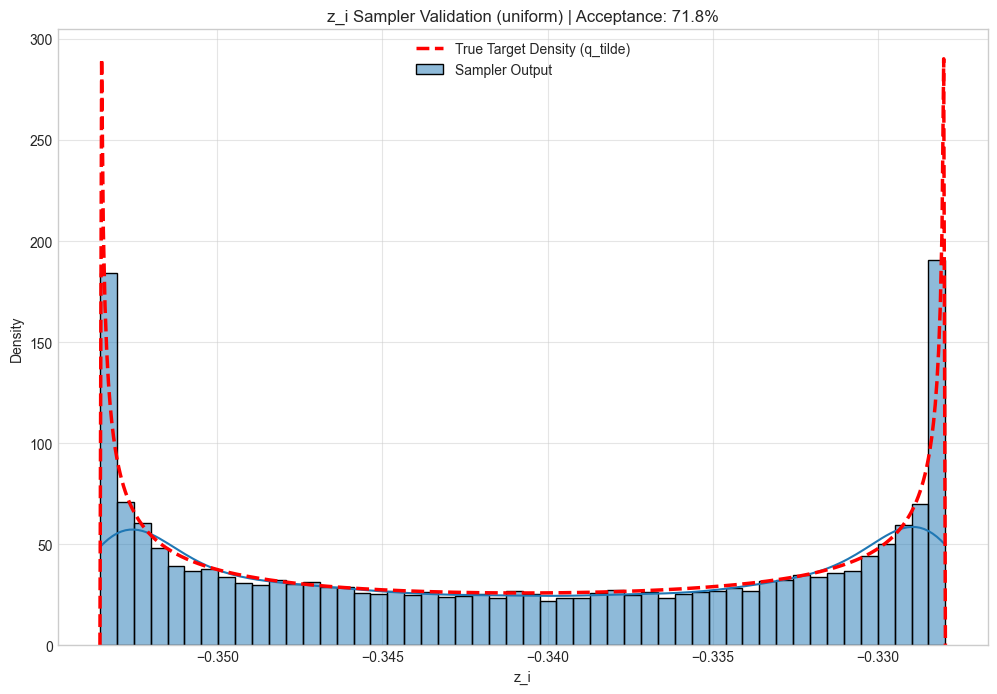

In [ ]:
# 1. CHOOSE YOUR PROPOSAL METHOD: 'gaussian', 'truncated_gaussian', or 'uniform'
proposal_method_to_test = 'uniform'


# 4. RUN THE TUNING FUNCTION
tune_and_plot_z_sampler(
    x_original=test_dataset_z,
    indices=test_indices_z,
    params=params,
    proposal_method=proposal_method_to_test,
    num_iterations=20000
)


In [25]:
test_dataset_z = x_original  
test_indices_z = test_indices_for_viz  # Use the same indices for z-sampling


--- Tuning Sampler for z_i with method: 'gaussian' ---
Proposal std dev = 0.200


Sampling z_i (gaussian):   0%|          | 0/19999 [00:00<?, ?it/s]

Acceptance Rate: 3.79%


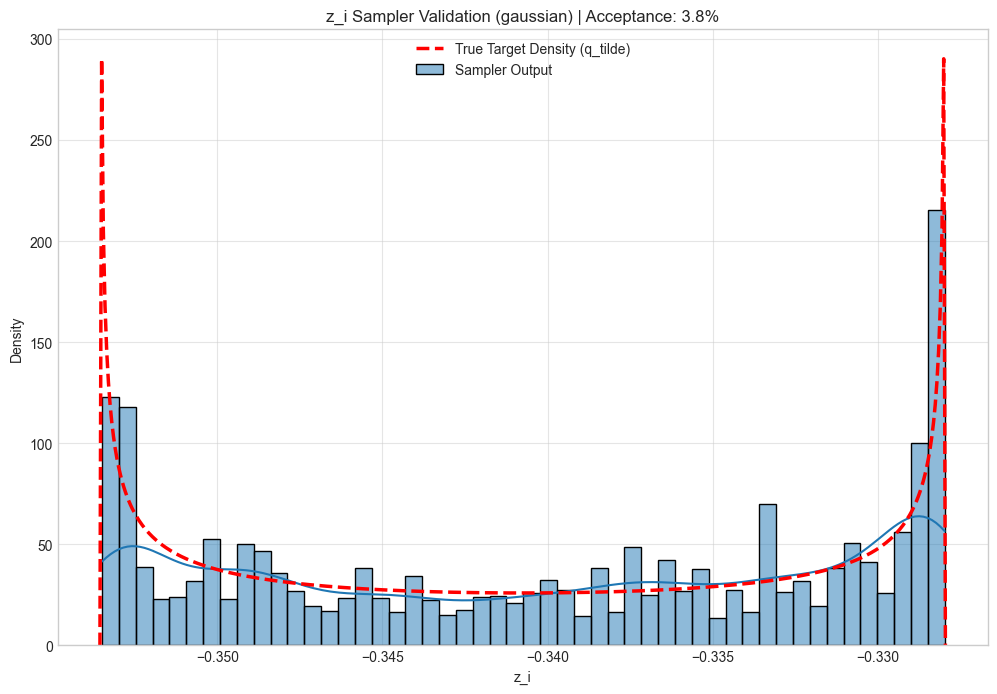

In [26]:
# 1. CHOOSE YOUR PROPOSAL METHOD: 'gaussian', 'truncated_gaussian', or 'uniform'
proposal_method_to_test = 'gaussian'

# 2. SET PROPOSAL STANDARD DEVIATION (for Gaussian methods)
params['proposal_std_z'] = 0.2


# 4. RUN THE TUNING FUNCTION
tune_and_plot_z_sampler(
    x_original=test_dataset_z,
    indices=test_indices_z,
    params=params,
    proposal_method=proposal_method_to_test,
    num_iterations=20000
)



--- Tuning Sampler for z_i with method: 'truncated_gaussian' ---
Proposal std dev = 0.002


Sampling z_i (truncated_gaussian):   0%|          | 0/19999 [00:00<?, ?it/s]

Acceptance Rate: 79.93%


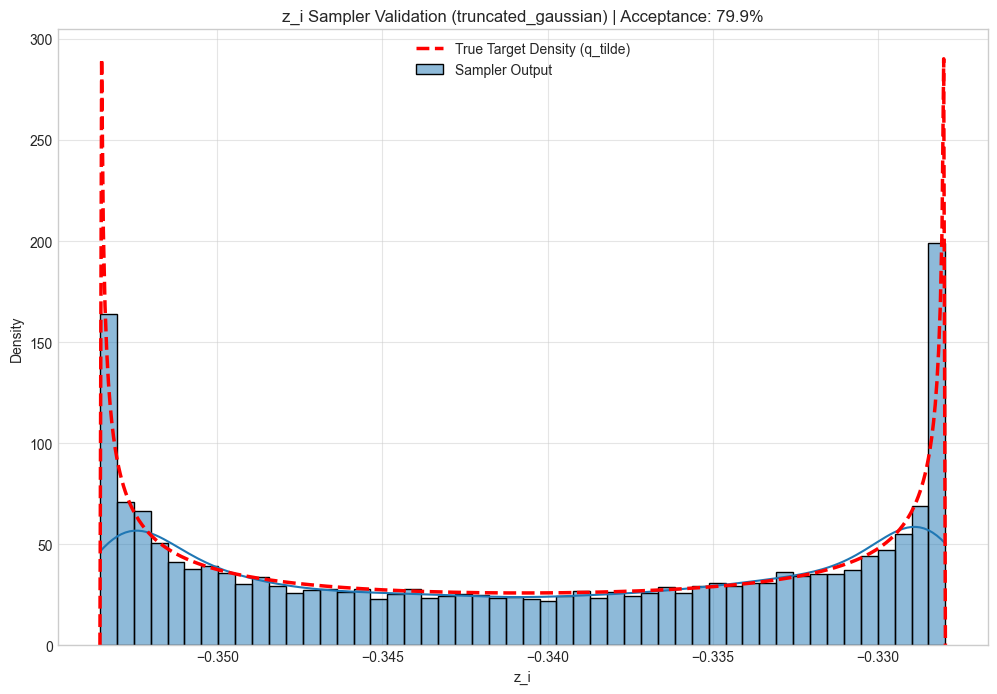

In [33]:
# 1. CHOOSE YOUR PROPOSAL METHOD: 'gaussian', 'truncated_gaussian', or 'uniform'
proposal_method_to_test = 'truncated_gaussian'

# 2. SET PROPOSAL STANDARD DEVIATION (for Gaussian methods)
params['proposal_std_z'] = 0.002


# 4. RUN THE TUNING FUNCTION
tune_and_plot_z_sampler(
    x_original=test_dataset_z,
    indices=test_indices_z,
    params=params,
    proposal_method=proposal_method_to_test,
    num_iterations=20000
)


In [34]:
# --- Block 10: The Main Pairwise Update Function  ---

def update_one_pair(x_current, indices, mu_current, params):
    """
    Performs the full 6-step constrained pairwise update for indices (i, j).

    Returns:
        (np.array, bool, bool): A tuple containing:
                                - The new data vector.
                                - A boolean for whether the PAIR was updated.
                                - A boolean for whether the Z_I proposal was accepted.
    """
    i, j = indices
    k = params['k']
    mu_star = params['mu_star']

    # --- Step 1: Calculate delta ---
    y_i, y_j = x_current[i] - mu_star, x_current[j] - mu_star
    z_i, z_j = psi(y_i, k), psi(y_j, k)
    delta = z_i + z_j

    # --- Step 2: Sample z_tilde_i ---
    z_tilde_i, z_i_accepted = sample_z_i(
        z_start=z_i, delta=delta, mu_current=mu_current, mu_star=mu_star, k=k,
        z_domain=params['z_domain'], proposal_std_z=params['proposal_std_z'], proposal_method='uniform'
    )

    # --- Step 3: Set Partner and Check Domain ---
    z_tilde_j = delta - z_tilde_i
    if not (params['z_domain'][0] < z_tilde_j < params['z_domain'][1]):
        return x_current, False, z_i_accepted

    # --- Step 4: Compute inverse branches ---
    y_i_minus, y_i_plus = psi_inverse(z_tilde_i, k)
    y_j_minus, y_j_plus = psi_inverse(z_tilde_j, k)

    # --- Step 5: Assign weights to each of the 4 pairs ---

    # create two arrays.
    # One for all the y_i candidates and one for all the y_j candidates.
    y_i_cands = np.array([y_i_minus, y_i_minus, y_i_plus, y_i_plus])
    y_j_cands = np.array([y_j_minus, y_j_plus, y_j_minus, y_j_plus])

    # Now call f_y only twice on the entire arrays.
    weights_i = f_y(y_i_cands, mu_current, mu_star, k)
    weights_j = f_y(y_j_cands, mu_current, mu_star, k)

    # The final weights are the element-wise product of the two arrays.
    weights = weights_i * weights_j

    # --- Step 6: Sample a pair  ---
    sum_of_weights = np.sum(weights)
    if sum_of_weights <= 0 or np.isnan(sum_of_weights):
        return x_current, False, z_i_accepted

    probs = weights / sum_of_weights

    # We need the original list of tuples to select the winner from
    candidate_y_pairs = [(y_i_minus, y_j_minus), (y_i_minus, y_j_plus), (y_i_plus, y_j_minus), (y_i_plus, y_j_plus)]
    chosen_index = np.random.choice(4, p=probs)
    y_i_new, y_j_new = candidate_y_pairs[chosen_index]

    x_i_new = y_i_new + mu_star
    x_j_new = y_j_new + mu_star

    x_new = np.copy(x_current)
    x_new[i], x_new[j] = x_i_new, x_j_new

    return x_new, True, z_i_accepted

In [35]:
# --- Block 11: The Full Systematic Scan Function for x ---

def update_x_full(x_current, mu_current, params):
    """
    Performs a full systematic scan to update the entire x vector.

    Returns:
        (np.array, int, int): A tuple containing:
                              - The new, fully updated data vector.
                              - The number of accepted PAIRS.
                              - The number of accepted Z_I proposals.
    """
    x_to_update = np.copy(x_current)
    m = params['m']
    pair_accepted_count = 0
    z_i_accepted_count = 0

    shuffled_indices = np.random.permutation(m)

    for i in range(0, m, 2):
        if i + 1 < m:
            indices = (shuffled_indices[i], shuffled_indices[i+1])

            x_to_update, pair_accepted, z_i_accepted = update_one_pair(
                x_to_update, indices, mu_current, params
            )
            if pair_accepted:
                pair_accepted_count += 1
            if z_i_accepted:
                z_i_accepted_count += 1

    return x_to_update, pair_accepted_count, z_i_accepted_count


In [36]:
# --- Block 12: The Main Gibbs Sampler Loop (with tqdm progress bar) ---
from tqdm.notebook import tqdm

print("\n--- Starting the Main Gibbs Sampler ---")
params['num_iterations_T'] = 25000
T = params['num_iterations_T']

# --- Containers for MCMC chains and statistics ---
mu_chain = np.zeros(T)
mu_chain[0] = mu_0 # From initialization block

x_mean_chain = np.zeros(T)
x_std_chain = np.zeros(T)
x_quartiles_chain = np.zeros((T, 3))

# Initialize stats at t=0
x_current = x_0 # From initialization block
x_mean_chain[0] = np.mean(x_current)
x_std_chain[0] = np.std(x_current)
x_quartiles_chain[0, :] = np.percentile(x_current, [25, 50, 75])

# Counters for acceptance rates
mu_acceptance_count = 0
x_pair_acceptance_count = 0
z_i_acceptance_count = 0
total_pairs_attempted = (T - 1) * (params['m'] // 2)

for t in tqdm(range(1, T), desc="Running Gibbs Sampler"):
    # --- Step (a): Sample mu(t) ---
    mu_previous = mu_chain[t-1]
    mu_new = update_mu_metropolis(mu_previous, x_current, params)
    mu_chain[t] = mu_new
    if mu_new != mu_previous:
        mu_acceptance_count += 1

    # --- Step (b): Sample x(t) ---
    x_new, accepted_pairs, accepted_z_is = update_x_full(x_current, mu_new, params)
    x_current = x_new # Update x_current for the next iteration

    x_pair_acceptance_count += accepted_pairs
    z_i_acceptance_count += accepted_z_is

    # --- Record statistics for the new x_current ---
    x_mean_chain[t] = np.mean(x_current)
    x_std_chain[t] = np.std(x_current)
    x_quartiles_chain[t, :] = np.percentile(x_current, [25, 50, 75])


# Calculate final rates
mu_acceptance_rate = mu_acceptance_count / (T - 1)
x_pair_acceptance_rate = x_pair_acceptance_count / total_pairs_attempted
z_i_acceptance_rate = z_i_acceptance_count / total_pairs_attempted


print(f"\n--- Sampling Complete ---")
print(f"Metropolis-Hastings acceptance rate for mu: {mu_acceptance_rate:.2%}")
print(f"Constrained pairwise acceptance rate for x: {x_pair_acceptance_rate:.2%}")
print(f"Nested M-H acceptance rate for z_i: {z_i_acceptance_rate:.2%}")


--- Starting the Main Gibbs Sampler ---


Running Gibbs Sampler:   0%|          | 0/24999 [00:00<?, ?it/s]


--- Sampling Complete ---
Metropolis-Hastings acceptance rate for mu: 30.70%
Constrained pairwise acceptance rate for x: 100.00%
Nested M-H acceptance rate for z_i: 61.35%



--- Posterior Analysis ---
Total Samples: 25000
Burn-in samples discarded: 2500
Samples used for analysis: 22500
--------------------
Posterior Mean of μ: 9.4384
Posterior Standard Deviation of μ: 0.2467
95% Credible Interval for μ: (8.9522, 9.9241)
True value of μ was: 10.0000


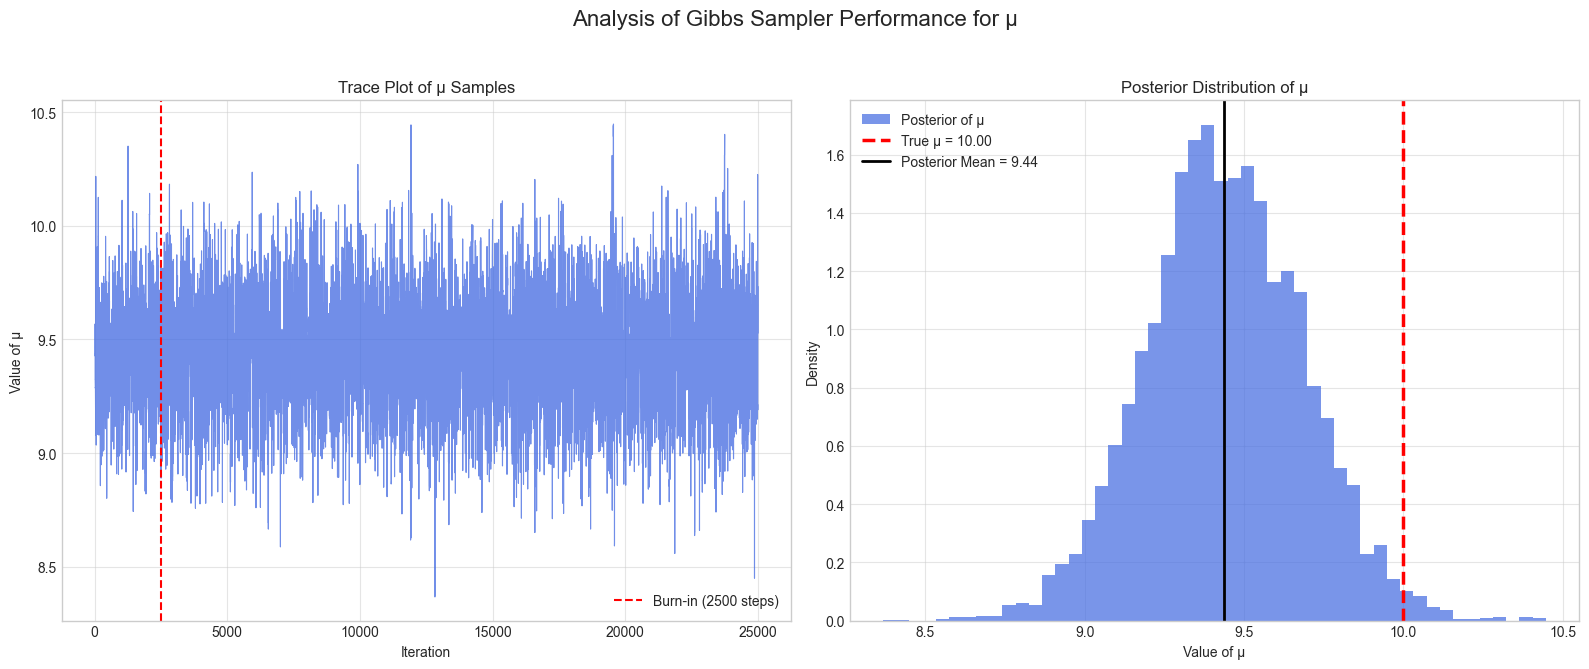

In [37]:
# --- Final Plots and Analysis of the mu Chain ---


# 1. Define a "burn-in" period to discard initial samples.
burn_in_fraction = 0.1
burn_in_steps = int(params['num_iterations_T'] * burn_in_fraction)
posterior_samples = mu_chain[burn_in_steps:]

print("\n--- Posterior Analysis ---")
posterior_mean = np.mean(posterior_samples)
posterior_std = np.std(posterior_samples)
credible_interval = np.percentile(posterior_samples, [2.5, 97.5])

print(f"Total Samples: {params['num_iterations_T']}")
print(f"Burn-in samples discarded: {burn_in_steps}")
print(f"Samples used for analysis: {len(posterior_samples)}")
print("-" * 20)
print(f"Posterior Mean of μ: {posterior_mean:.4f}")
print(f"Posterior Standard Deviation of μ: {posterior_std:.4f}")
print(f"95% Credible Interval for μ: ({credible_interval[0]:.4f}, {credible_interval[1]:.4f})")
print(f"True value of μ was: {params['mu_true']:.4f}")

# 2. Create the plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: The Trace Plot
axes[0].plot(mu_chain, color='royalblue', alpha=0.75, lw=0.8)
axes[0].axvline(burn_in_steps, color='red', linestyle='--', label=f'Burn-in ({burn_in_steps} steps)')
axes[0].set_title("Trace Plot of μ Samples")
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel("Value of μ")
axes[0].legend()
axes[0].grid(True, alpha=0.5)

# Plot 2: The Posterior Density Histogram
axes[1].hist(posterior_samples, bins=50, density=True, color='royalblue', alpha=0.7, label="Posterior of μ")
axes[1].axvline(params['mu_true'], color='red', linestyle='--', linewidth=2.5, label=f"True μ = {params['mu_true']:.2f}")
axes[1].axvline(posterior_mean, color='black', linestyle='-', linewidth=2, label=f"Posterior Mean = {posterior_mean:.2f}")
axes[1].set_title("Posterior Distribution of μ")
axes[1].set_xlabel("Value of μ")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True, alpha=0.5)


plt.suptitle("Analysis of Gibbs Sampler Performance for μ", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/var/folders/q7/v7x9p15j5mxcfyv0j1hwnkqr0000gn/T/ipykernel_76001/823762192.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend()


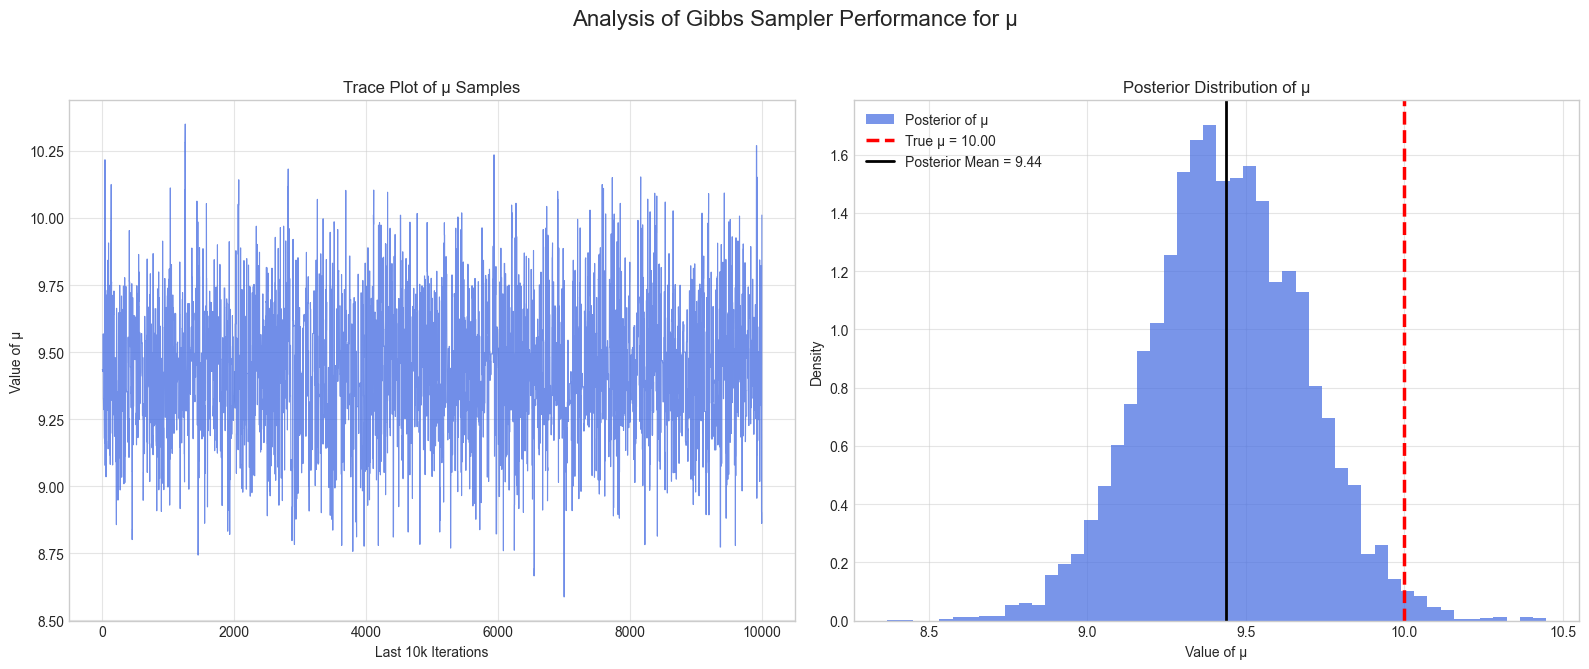

In [38]:
# 2. Create the plots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: The Trace Plot
axes[0].plot(mu_chain[:10000], color='royalblue', alpha=0.75, lw=0.8)
# axes[0].axvline(burn_in_steps, color='red', linestyle='--', label=f'Burn-in ({burn_in_steps} steps)')
axes[0].set_title("Trace Plot of μ Samples")
axes[0].set_xlabel("Last 10k Iterations")
axes[0].set_ylabel("Value of μ")
axes[0].legend()
axes[0].grid(True, alpha=0.5)

# Plot 2: The Posterior Density Histogram
axes[1].hist(posterior_samples, bins=50, density=True, color='royalblue', alpha=0.7, label="Posterior of μ")
axes[1].axvline(params['mu_true'], color='red', linestyle='--', linewidth=2.5, label=f"True μ = {params['mu_true']:.2f}")
axes[1].axvline(posterior_mean, color='black', linestyle='-', linewidth=2, label=f"Posterior Mean = {posterior_mean:.2f}")
axes[1].set_title("Posterior Distribution of μ")
axes[1].set_xlabel("Value of μ")
axes[1].set_ylabel("Density")
axes[1].legend()
axes[1].grid(True, alpha=0.5)


plt.suptitle("Analysis of Gibbs Sampler Performance for μ", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


--- Analyzing Convergence of x-statistics ---


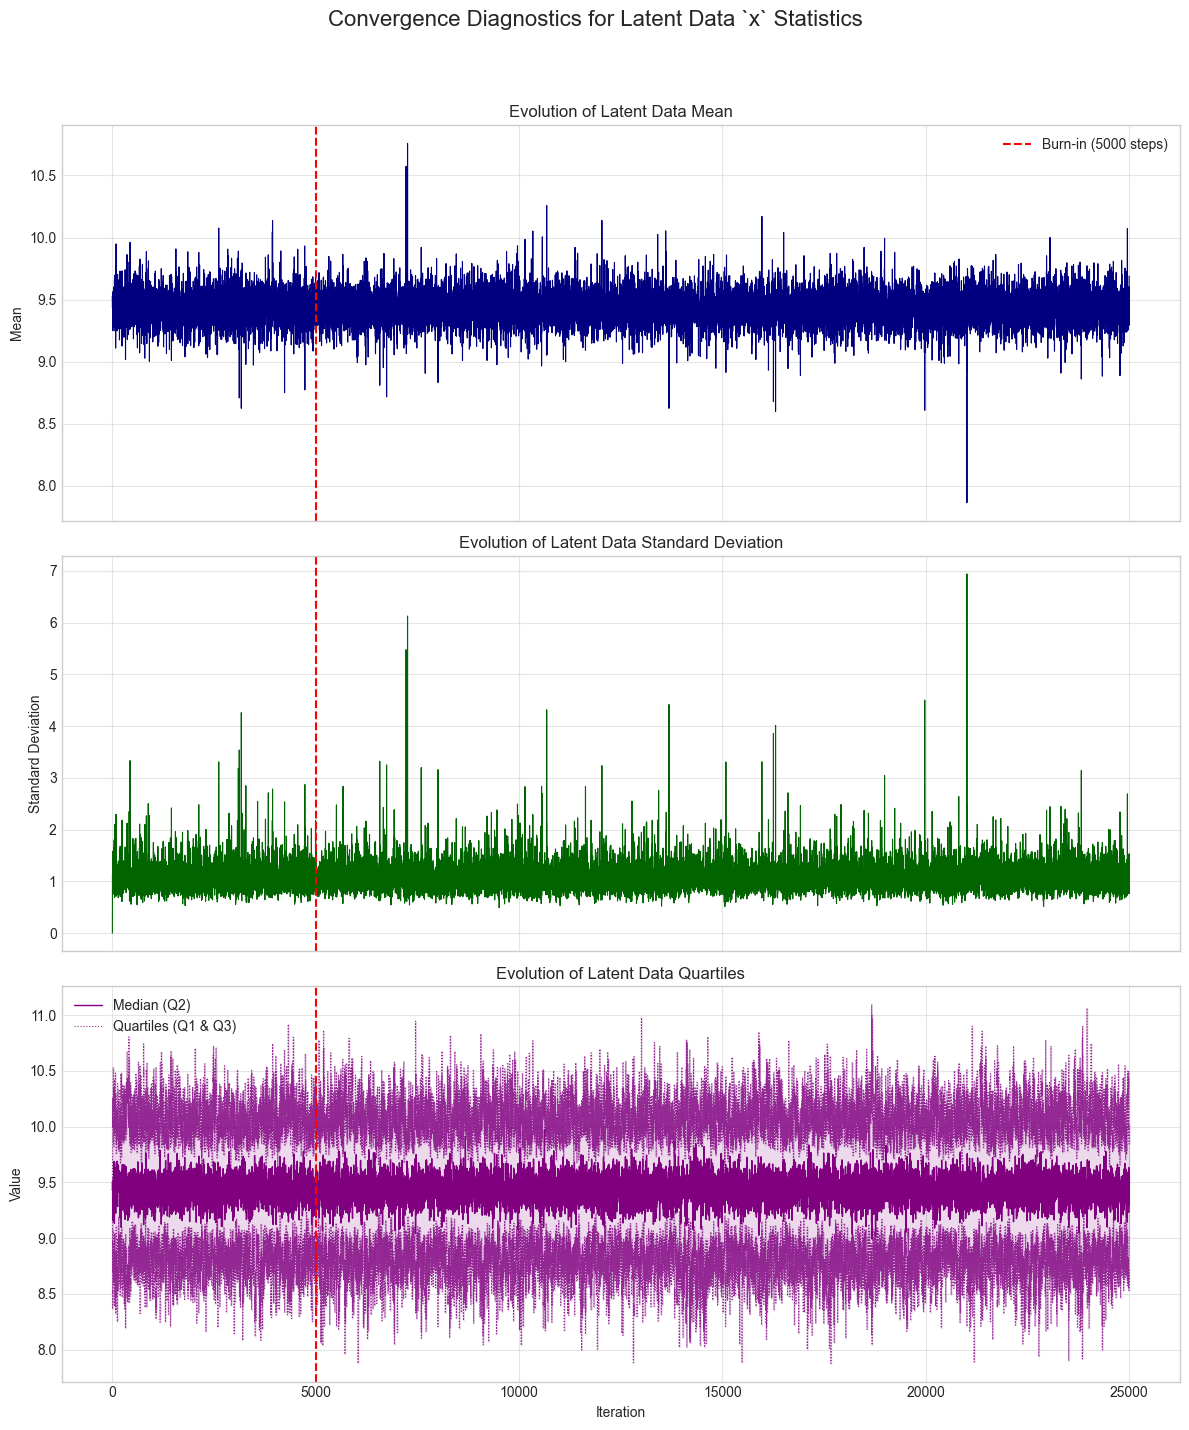

In [39]:
# --- New Block: Convergence Diagnostics for Latent Data x ---

print("\n--- Analyzing Convergence of x-statistics ---")

# Use the same burn-in period as for mu
burn_in = int(params['num_iterations_T'] * 0.2)

# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

# Plot 1: Evolution of the Mean of x
axes[0].plot(x_mean_chain, lw=0.8, color='navy')
axes[0].axvline(burn_in, color='red', linestyle='--', label=f'Burn-in ({burn_in} steps)')
axes[0].set_ylabel("Mean")
axes[0].set_title("Evolution of Latent Data Mean")
axes[0].legend()
axes[0].grid(True, alpha=0.5)

# Plot 2: Evolution of the Standard Deviation of x
axes[1].plot(x_std_chain, lw=0.8, color='darkgreen')
axes[1].axvline(burn_in, color='red', linestyle='--')
axes[1].set_ylabel("Standard Deviation")
axes[1].set_title("Evolution of Latent Data Standard Deviation")
axes[1].grid(True, alpha=0.5)

# Plot 3: Evolution of the Quartiles of x
q1 = x_quartiles_chain[:, 0]
median = x_quartiles_chain[:, 1]
q3 = x_quartiles_chain[:, 2]
axes[2].plot(median, lw=1, color='purple', label='Median (Q2)')
axes[2].plot(q1, lw=0.8, linestyle=':', color='purple', alpha=0.8, label='Quartiles (Q1 & Q3)')
axes[2].plot(q3, lw=0.8, linestyle=':', color='purple', alpha=0.8)
axes[2].fill_between(range(T), q1, q3, color='purple', alpha=0.15)
axes[2].axvline(burn_in, color='red', linestyle='--')
axes[2].set_xlabel("Iteration")
axes[2].set_ylabel("Value")
axes[2].set_title("Evolution of Latent Data Quartiles")
axes[2].legend()
axes[2].grid(True, alpha=0.5)

plt.suptitle("Convergence Diagnostics for Latent Data `x` Statistics", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [40]:
# --- Block 14: Validation using Simulation and KDE ---


print("\n--- Starting Validation Procedure ---")
N = 10000  # Number of simulations
mu_for_kde = 0.0 # The base value of mu for building the likelihood

# --- Phase 1: Empirically Construct the Base Likelihood p(μ̂ | μ=0) ---
print(f"Phase 1: Generating {N} datasets to build the likelihood. This will take some time...")

mle_samples_for_kde = np.zeros(N)

for i in range(N):
    # Simulate one dataset with mu = 0.0
    sim_data = stats.t.rvs(df=params['k'], loc=mu_for_kde, scale=1, size=params['m'])

    # Calculate its MLE
    res = optimize.minimize(
        fun=negative_log_likelihood,
        x0=np.mean(sim_data),
        args=(sim_data, params['k']),
        method='BFGS' # A robust optimization method
    )
    mle_samples_for_kde[i] = res.x[0]

    # Progress indicator
    if (i + 1) % (N // 10) == 0:
        print(f"  ... {i+1}/{N} simulations complete.")

# Use the N calculated MLEs to build the Kernel Density Estimate
kde_0 = stats.gaussian_kde(mle_samples_for_kde, bw_method=0.1)
print("Phase 1 Complete: KDE for base likelihood has been constructed.")


# --- Phase 2 & 3: Construct and Plot the Benchmark Posterior ---
print("Phase 2 & 3: Calculating benchmark posterior and plotting for comparison.")

# Create a grid of mu values to evaluate the posterior on.
# We'll use the range from our Gibbs sampler's output for a good comparison.
mu_grid = np.linspace(credible_interval[0] - 1, credible_interval[1] + 1, 400)

# Phase 2: Calculate the likelihood p(μ*|μ) for each mu in the grid using the shift property
likelihood_kde = kde_0.pdf(params['mu_star'] - mu_grid)

# Phase 3: Multiply by the prior to get the unnormalized posterior
prior_on_grid = stats.norm.pdf(mu_grid, loc=params['prior_mean'], scale=params['prior_std'])
unnormalized_posterior_kde = likelihood_kde * prior_on_grid

# Normalize the benchmark posterior so its area is 1, just like the histogram
# We can use the trapezoidal rule to approximate the integral.
area = np.trapezoid(unnormalized_posterior_kde, mu_grid)
benchmark_posterior = unnormalized_posterior_kde / area


# --- Validation Plot ---
plt.figure(figsize=(12, 8))

# Plot the histogram of our Gibbs sampler's results
plt.hist(posterior_samples[:2500], bins=50, density=True, color='royalblue', alpha=0.6, label="Posterior from Gibbs Sampler")

# Overlay the benchmark posterior calculated via the KDE method
plt.plot(mu_grid, benchmark_posterior, color='red', linestyle='-', linewidth=2.5, label="Benchmark Posterior (KDE Method)")

plt.axvline(params['mu_true'], color='black', linestyle='--', linewidth=2, label=f"True μ = {params['mu_true']:.2f}")
plt.title("Validation: Gibbs Sampler vs. Benchmark Posterior", fontsize=16)
plt.xlabel("Value of μ")
plt.ylabel("Density")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.5)
plt.show()


--- Starting Validation Procedure ---
Phase 1: Generating 10000 datasets to build the likelihood. This will take some time...


NameError: name 'negative_log_likelihood' is not defined

In [42]:
len(posterior_samples)

22500

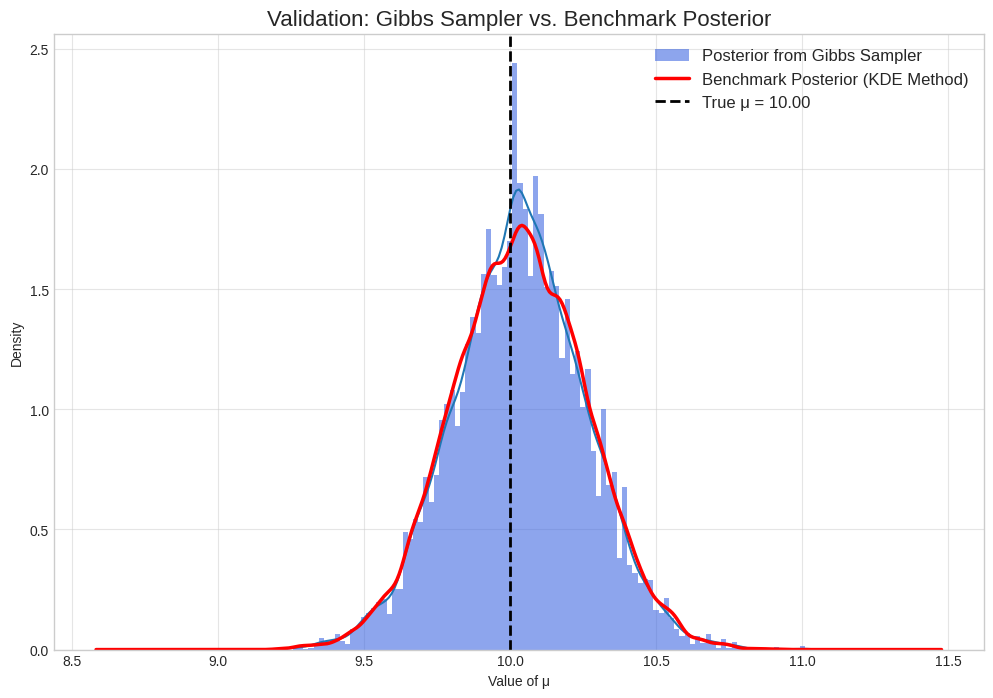

In [ ]:
plt.figure(figsize=(12, 8))

# Plot the histogram of our Gibbs sampler's results
plt.hist(posterior_samples[:], bins=100, density=True, color='royalblue', alpha=0.6, label="Posterior from Gibbs Sampler")
sns.kdeplot(posterior_samples[:])
# Overlay the benchmark posterior calculated via the KDE method
plt.plot(mu_grid, benchmark_posterior, color='red', linestyle='-', linewidth=2.5, label="Benchmark Posterior (KDE Method)")

plt.axvline(params['mu_true'], color='black', linestyle='--', linewidth=2, label=f"True μ = {params['mu_true']:.2f}")
plt.title("Validation: Gibbs Sampler vs. Benchmark Posterior", fontsize=16)
plt.xlabel("Value of μ")
plt.ylabel("Density")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.5)
plt.show()

In [ ]:
# --- Block E1-B: Comparing Gibbs Posterior vs. True Full-Data Posterior ---

print("\n--- Experiment 1: Comparing Posteriors (Sampler vs. True Analytical) ---")

# --- 1. Get the samples from the main Gibbs sampler (for p(μ|μ*)) ---
# This chain should already be in memory from running Block 12
burn_in = int(params['num_iterations_T'] * 0.2)
posterior_mle_samples = mu_chain[burn_in:]

# --- 2. Calculate the True Analytical Posterior given the Full Data, p(μ|x) ---
print("Calculating the true normalized posterior density for the full data...")
# Create a fine grid of mu values to plot over
mu_grid = np.linspace(posterior_mle_samples.min() - 1, posterior_mle_samples.max() + 1, 500)

# The data is fixed to the complete, original dataset
fixed_x = x_original

# Calculate the unnormalized posterior value at each grid point
# We simply exponentiate our log_posterior_mu function
unnormalized_posterior_full = np.exp([log_posterior_mu(mu, fixed_x, params['k'], params['prior_mean'], params['prior_std']) for mu in mu_grid])

# Normalize the curve by dividing by its total area
integral_area = np.trapezoid(unnormalized_posterior_full, mu_grid)
true_posterior_full_data = unnormalized_posterior_full / integral_area

# --- 3. Quantitative Comparison ---
mean_mle = np.mean(posterior_mle_samples)
std_mle = np.std(posterior_mle_samples)
# For the true posterior, we can calculate its mean and std from the grid
mean_full = np.trapezoid(mu_grid * true_posterior_full_data, mu_grid)
std_full = np.sqrt(np.trapezoid((mu_grid - mean_full)**2 * true_posterior_full_data, mu_grid))

print(f"Posterior from MLE only (Sampler): Mean = {mean_mle:.4f}, Std Dev = {std_mle:.4f}")
print(f"Posterior from Full Data (True):   Mean = {mean_full:.4f}, Std Dev = {std_full:.4f}")



--- Experiment 1: Comparing Posteriors (Sampler vs. True Analytical) ---
Calculating the true normalized posterior density for the full data...
Posterior from MLE only (Sampler): Mean = 10.0336, Std Dev = 0.2263
Posterior from Full Data (True):   Mean = 10.0308, Std Dev = 0.2325


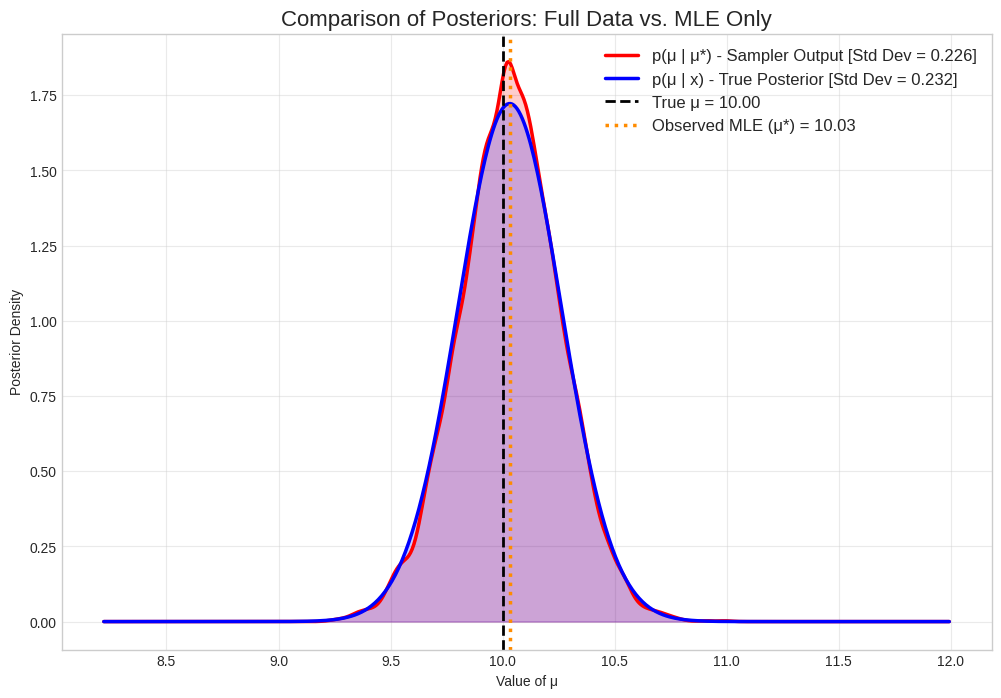

In [ ]:
# --- Visual Comparison (with MLE line added) ---
plt.figure(figsize=(12, 8))

# Plot the KDE of our Gibbs sampler's output (p(μ|μ*))
kde_mle = stats.gaussian_kde(posterior_mle_samples)
plt.plot(mu_grid, kde_mle(mu_grid), color='red', lw=2.5, label=f"p(μ | μ*) - Sampler Output [Std Dev = {std_mle:.3f}]")
plt.fill_between(mu_grid, kde_mle(mu_grid), color='red', alpha=0.2)

# Plot the true analytical posterior curve (p(μ|x))
plt.plot(mu_grid, true_posterior_full_data, color='blue', lw=2.5, label=f"p(μ | x) - True Posterior [Std Dev = {std_full:.3f}]")
plt.fill_between(mu_grid, true_posterior_full_data, color='blue', alpha=0.2)

# Add reference lines
plt.axvline(params['mu_true'], color='black', linestyle='--', linewidth=2, label=f"True μ = {params['mu_true']:.2f}")

# NEW: Add a vertical line for the observed MLE
plt.axvline(params['mu_star'], color='darkorange', linestyle=':', linewidth=2.5, label=f"Observed MLE (μ*) = {params['mu_star']:.2f}")

plt.title("Comparison of Posteriors: Full Data vs. MLE Only", fontsize=16)
plt.xlabel("Value of μ")
plt.ylabel("Posterior Density")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.4)
plt.show()



In [ ]:
# --- Block E2 (Corrected): Posterior Predictive Check for x ---
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
from IPython.display import display

print("\n--- Experiment 2: Posterior Predictive Check for x ---")

# --- 1. Get the posterior samples for mu from the main Gibbs run ---
# This chain should already be in memory from running Block 12
burn_in = int(params['num_iterations_T'] * 0.2)
posterior_mle_samples = mu_chain[burn_in:]

# --- 2. Generate x vectors from the posterior of mu ---
num_x_samples_to_gen = 2000
mus_for_prediction = np.random.choice(posterior_mle_samples, size=num_x_samples_to_gen, replace=True)
x_samples_storage = []

print(f"Generating {num_x_samples_to_gen} new x vectors based on the posterior of μ...")
for mu in tqdm(mus_for_prediction, desc="Generating x samples"):
    x_new = stats.t.rvs(df=params['k'], loc=mu, scale=1, size=params['m'])
    x_samples_storage.append(x_new)



--- Experiment 2: Posterior Predictive Check for x ---
Generating 2000 new x vectors based on the posterior of μ...


Generating x samples:   0%|          | 0/2000 [00:00<?, ?it/s]


Side-by-Side Comparison of Data Statistics:


,Mean,Std. Dev.,10th Percentile,25th Percentile (Q1),Median (50th),75th Percentile (Q3),90th Percentile
Ground Truth (x_original),10.0272,1.1680,8.6765,9.1725,9.9855,10.7140,11.4150
Generated Latent (x̃),10.0257,1.3173,8.5231,9.2831,10.0284,10.7760,11.5261


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 771 (\N{COMBINING TILDE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


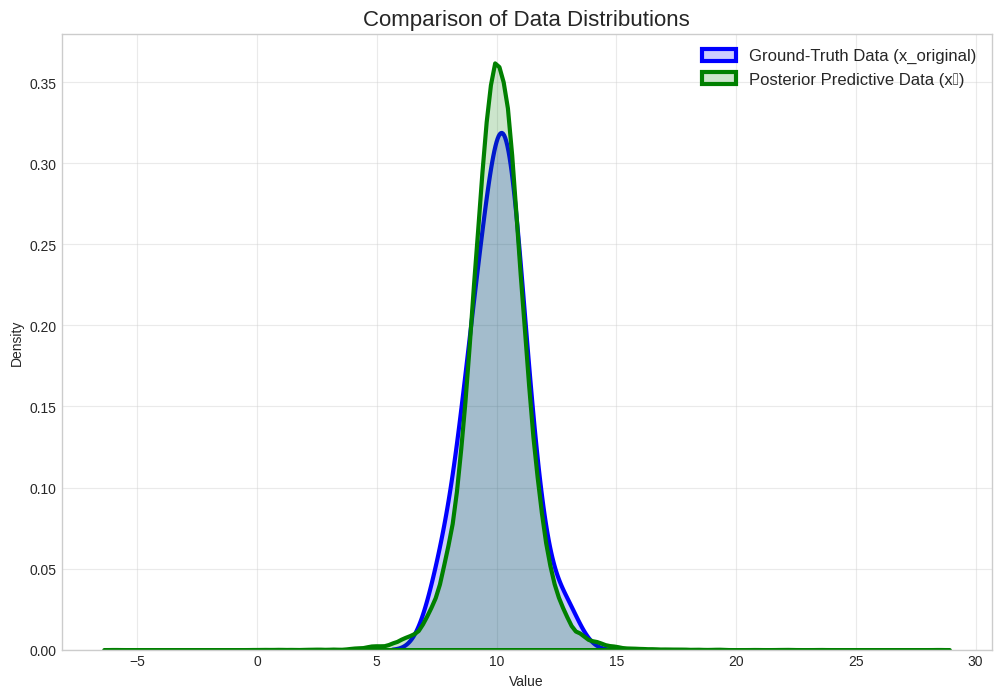

In [ ]:

# --- 3. Perform Quantitative Comparison ---
ground_truth_x = x_original
generated_latent_x = np.array(x_samples_storage).flatten()

stats_to_compare = {
    "Mean": [np.mean(ground_truth_x), np.mean(generated_latent_x)],
    "Std. Dev.": [np.std(ground_truth_x), np.std(generated_latent_x)],
    "10th Percentile": [np.percentile(ground_truth_x, 10), np.percentile(generated_latent_x, 10)],
    "25th Percentile (Q1)": [np.percentile(ground_truth_x, 25), np.percentile(generated_latent_x, 25)],
    "Median (50th)": [np.percentile(ground_truth_x, 50), np.percentile(generated_latent_x, 50)],
    "75th Percentile (Q3)": [np.percentile(ground_truth_x, 75), np.percentile(generated_latent_x, 75)],
    "90th Percentile": [np.percentile(ground_truth_x, 90), np.percentile(generated_latent_x, 90)],
}
comparison_df = pd.DataFrame(stats_to_compare, index=["Ground Truth (x_original)", "Generated Latent (x̃)"])

# --- 4. Format and Display the Comparison Table ---
print("\nSide-by-Side Comparison of Data Statistics:")

styles = [
    dict(selector="th.col_heading", props=[("text-align", "center"), ("font-weight", "bold"), ("background-color", "#f2f2f2"), ("border", "1px solid black"), ("color", "black")]),
    dict(selector="th.row_heading", props=[("text-align", "left"), ("font-weight", "bold"), ("border", "1px solid black")]),
    dict(selector="td", props=[("text-align", "center"), ("border", "1px solid black")]),
    dict(selector="caption", props=[("caption-side", "top"), ("font-size", "1.2em"), ("font-weight", "bold"), ("margin-bottom", "10px")])
]
def highlight_std_high_contrast(s):
    is_std = s.name == 'Std. Dev.'
    return ['background-color: #4B6C8C; color: white; font-weight: bold' if is_std else '' for v in s]

styled_df = comparison_df.style.format("{:.4f}").set_caption("Side-by-Side Comparison of Data Statistics").set_table_styles(styles).apply(highlight_std_high_contrast, axis=1)

display(styled_df) # This will now work correctly

# --- 5. Visual Comparison with Density Plots ---
plt.figure(figsize=(12, 8))
sns.kdeplot(ground_truth_x, color='blue', lw=3, label='Ground-Truth Data (x_original)', fill=True, alpha=0.2)
sns.kdeplot(generated_latent_x, color='green', lw=3, label='Posterior Predictive Data (x̃)', fill=True, alpha=0.2)
plt.title("Comparison of Data Distributions", fontsize=16)
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend(fontsize=12)
plt.grid(True, alpha=0.4)
plt.show()


--- Visual Comparison: Q-Q Plot ---


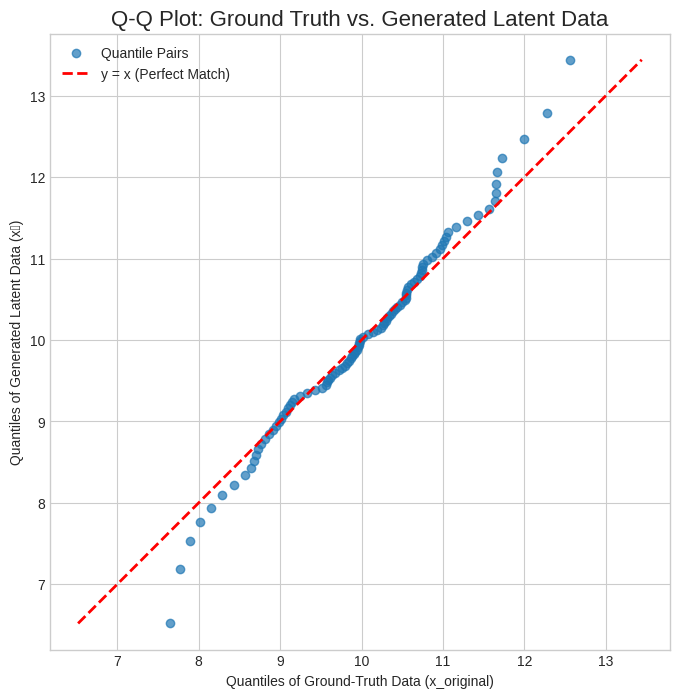

In [ ]:
# --- Alternative Visualization: Q-Q Plot ---
import numpy as np
import matplotlib.pyplot as plt

# This assumes 'ground_truth_x' and 'generated_latent_x' are in memory
print("\n--- Visual Comparison: Q-Q Plot ---")

# 1. Define the percentiles we want to compare (from 1st to 99th)
percentiles = np.linspace(1, 99, 100)

# 2. Calculate the quantiles for each dataset
quantiles_ground_truth = np.percentile(ground_truth_x, percentiles)
quantiles_generated = np.percentile(generated_latent_x, percentiles)

# 3. Create the plot
plt.figure(figsize=(8, 8))
plt.scatter(quantiles_ground_truth, quantiles_generated, alpha=0.7, label='Quantile Pairs')

# Add the 45-degree line for reference
# Find the limits to make a perfect diagonal line
lim_min = min(quantiles_ground_truth.min(), quantiles_generated.min())
lim_max = max(quantiles_ground_truth.max(), quantiles_generated.max())
plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', lw=2, label='y = x (Perfect Match)')

plt.title("Q-Q Plot: Ground Truth vs. Generated Latent Data", fontsize=16)
plt.xlabel("Quantiles of Ground-Truth Data (x_original)")
plt.ylabel("Quantiles of Generated Latent Data (x̃)")
plt.legend()
plt.grid(True)
plt.axis('equal') # Ensure the plot is square for a proper 45-degree line
plt.show()


--- Visual Comparison: Side-by-Side Box Plots ---


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 771 (\N{COMBINING TILDE}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


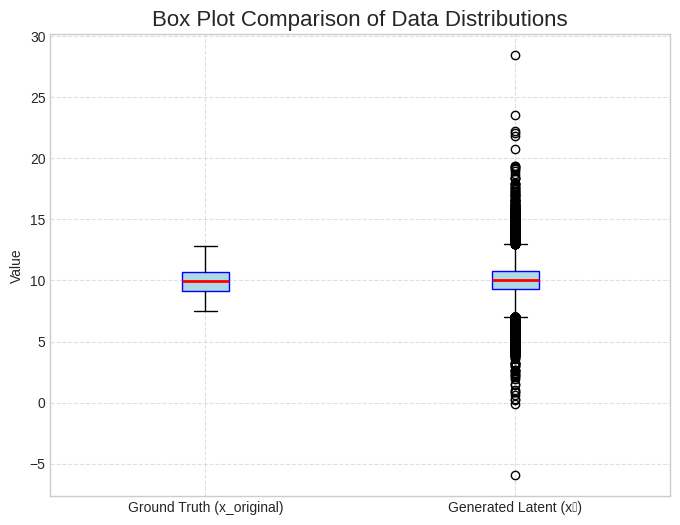

In [ ]:
# --- Alternative Visualization: Side-by-Side Box Plots ---

print("\n--- Visual Comparison: Side-by-Side Box Plots ---")

plt.figure(figsize=(8, 6))

# plt.boxplot expects a list of datasets
data_to_plot = [ground_truth_x, generated_latent_x]

plt.boxplot(data_to_plot, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2))

plt.title("Box Plot Comparison of Data Distributions", fontsize=16)
plt.xticks([1, 2], ['Ground Truth (x_original)', 'Generated Latent (x̃)'])
plt.ylabel("Value")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()